In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
import re
import nltk
import chart_studio
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
import plotly.graph_objects as go
import chart_studio.plotly as py
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from chart_studio.plotly import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

In [2]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250

EMBEDDING_DIM = 100

In [3]:
class Lstm_issue():

    def __init__(self, data_location, data_location_ori = 'data/hadoop/HADOOP.csv', aug_mul = 2):
        self.data_ori = pd.read_csv(data_location_ori) # 원본 데이터
        self.aug_mul = aug_mul
        self.df = pd.read_csv(data_location, encoding='cp949')
        print(self.df.info())

        print(self.df.component.value_counts())

        
        self.data_ori['text'] = list(self.data_ori.title + " " + self.data_ori.description)

        for x in range(len(self.df.component)):
            self.df.component[x] = self.df.component[x].split(',')[0]

        self.Y = pd.get_dummies(self.df[set(self.df.component)])
        print(self.df.component.value_counts())

    def print_plot(self, index):
        example = self.df[self.df.index == index][['text', 'component']].values[0]
        if len(example) > 0:
            print(example[0])
            print('component:', example[1])

    def preprocessing(self):
        self.df = self.df.reset_index(drop=True)
        self.df = self.df.astype(str)
    
    def clean_text(self):
        '''self.df['text'] = self.df['text'].apply(_clean_text)
        self.df['text'] = self.df['text'].str.replace('\d+', '')'''
        refined_data = []
        for item in self.df['text']:
            #1. Remove \r 
            current_desc = item.replace('\r', ' ')    
            #2. Remove URLs
            current_desc = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', current_desc)    
            #4. Remove hex code
            current_desc = re.sub(r'(\w+)0x\w+', '', current_desc) 
            #5. Change to lower case
            current_desc = current_desc.lower()   
            #6. Tokenize
            #current_desc_tokens = tokenizer(current_desc, add_special_tokens= True)
            #7. Strip trailing punctuation marks    
            #current_desc_filter = [word.strip(string.punctuation) for word in current_desc_tokens]     
            #8. Join the lists
            #current_data = current_desc_filter
            #current_data = list(filter(None, current_data))
            refined_data.append(current_desc)
        self.df['text'] = refined_data
        self.df['text'] = self.df['text'].str.replace('\d+', '')
    
    def tokenize_df(self):
        '''# The maximum number of words to be used. (most frequent)
        MAX_NB_WORDS = 50000
        # Max number of words in each complaint.
        MAX_SEQUENCE_LENGTH = 250
        # This is fixed.
        EMBEDDING_DIM = 100'''
        self.tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
        self.tokenizer.fit_on_texts(self.df['text'].values)
        word_index = self.tokenizer.word_index
        print('Found %s unique tokens.' % len(word_index))

    # 불러온 정제된 데이터 one hot을 str에서 list로 바꾸는 작업
    def labels_to_int(self):
        x, y = train_test_split(self.data_ori, test_size = 0.2, random_state=42)
        self.X_ori = x.text
        self.Y_ori = y.component

        #self.X_train, self.X_test, self.Y_train, self.Y_test = train_test_split(self.X_ori, self.Y_ori, test_size = 0.20, random_state = 21)

        # 증강데이터의 train_data에서 test index부분 제거
        y_index = list(y.index)
        #test_index_list = list(self.test_data.index)
        test_index =[]
        for aug_num in range(self.aug_mul):
            iidf2 = [i + 6152* aug_num for i in y_index]
            test_index = test_index + iidf2

        # labeling y
        #self.Y = pd.get_dummies(self.df['component'])
        df_compset = list(set(self.df.component.values))
        #self.Y = pd.get_dummies(self.df[set(self.df.component)])
        #self.Y = pd.get_dummies(self.df['fs'])
        
        self.X_train = self.df['text'].drop(test_index)
        self.X_train = self.X_train.sample(frac=1).reset_index(drop=True)
        X_train_index = list(self.X_train.index)
        self.X_test = self.df['text'].drop(X_train_index)
        self.X_test = self.X_test.sample(frac=1).reset_index(drop=True)

        self.Y_train = self.Y.drop(test_index)
        self.Y_train = self.Y_train.sample(frac=1).reset_index(drop=True)
        self.Y_test = self.Y.drop(X_train_index)
        self.Y_test = self.Y_test.sample(frac=1).reset_index(drop=True)
        # tokenize x, y
        self.X_train = self.tokenizer.texts_to_sequences(self.X_train.values)
        #self.X = self.tokenizer.texts_to_sequences(df_text_ori)
        self.X_train = pad_sequences(self.X_train, maxlen=MAX_SEQUENCE_LENGTH)

        self.X_test = self.tokenizer.texts_to_sequences(self.X_test.values)
        #self.X = self.tokenizer.texts_to_sequences(df_text_ori)
        self.X_test = pad_sequences(self.X_test, maxlen=MAX_SEQUENCE_LENGTH)
        print('X Shape of data tensor:', self.X_train.shape, self.X_test.shape)

        # tokenize x, y ori 
        self.X_ori = self.tokenizer.texts_to_sequences(self.X_ori.values)
        #self.X = self.tokenizer.texts_to_sequences(df_text_ori)
        self.X_ori = pad_sequences(self.X_ori, maxlen=MAX_SEQUENCE_LENGTH)
        print('X_ori Shape of data tensor:', self.X_train.shape, self.X_ori.shape)
        self.Y_ori = pd.get_dummies(self.Y_ori).values
        print('Shape of label tensor:', self.Y_ori.shape)

        '''print('xori, yori: ', self.X_ori.shape, self.Y_ori.shape)
        self.X_train_ori, self.X_test_ori, self.Y_train_ori, self.Y_test_ori = train_test_split(self.X_ori, self.Y_ori, test_size=0.2, random_state=42)'''
        
        '''self.Y_train = pd.get_dummies(self.Y_train).values
        self.Y_test = pd.get_dummies(self.Y_test).values'''
        print('Y Shape of label tensor:', self.Y_train.shape, self.Y_test.shape)

        print('X train Shape of data tensor:', self.X_train.shape,'X test: ', self.X_test.shape)
        print('Y Shape of label tensor:', self.Y_train.shape,'X test: ', self.Y_test.shape)
        
     
    def set_model(self, topk_num = 5):
        self.model = Sequential()
        self.model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=self.X_train.shape[1]))
        self.model.add(SpatialDropout1D(0.2))
        self.model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
        self.model.add(Dense(37, activation='sigmoid'))
        self.model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.Recall(top_k = topk_num), 'accuracy'])
    
    def set_model_cnn(self, topk_num = 5):
        model = Sequential()
        model.add(Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
        model.add(Dense(n_outputs, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam')
        return model

    def run_model(self):
        epochs = 20
        batch_size = 64

        self.history = self.model.fit(self.X_train, self.Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
    
    def run_model_ori(self):
        epochs = 5
        batch_size = 64

        self.history = self.model.fit(self.X_train_ori, self.Y_train_ori, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
    
    def test_model(self):
        self.accr = self.model.evaluate(self.X_test, self.Y_test)
        print('Test set\n Loss: {:0.3f}\n Accuracy: {0.3f}'.format(self.accr[0], self.accr[1]))

    def test_model_ori(self):
        self.accr = self.model.evaluate(self.X_test_ori, self.Y_test_ori)
        print('Test set\n Loss: {:0.3f}\n Accuracy: {0.3f}'.format(self.accr[0], self.accr[1]))


In [4]:
dataloc1 = "data/hadoop/HADOOP_char_Keyboard_ori.csv"
dataloc2 = "data/hadoop/HADOOP_char_OCR_ori.csv"
dataloc3 = "data/hadoop/HADOOP_word_Antonym_ori.csv"
dataloc4 = "data/hadoop/HADOOP_word_Spelling_ori.csv"
dataloc5 = "data/hadoop/HADOOP_word_Split_ori.csv"
dataloc6 = "data/hadoop/HADOOP_word_Synonym_ori.csv"
dataloc7 = "data/hadoop/HADOOP_word_TfidfAug_ori.csv"
dataloc8 = "data/hadoop/HADOOP_word_ContextualWordEmbs_ori.csv"

pius_word1 = Lstm_issue(dataloc1)
pius_word2 = Lstm_issue(dataloc2)
pius_word3 = Lstm_issue(dataloc3)
pius_word4 = Lstm_issue(dataloc4)
pius_word5 = Lstm_issue(dataloc5)
pius_word6 = Lstm_issue(dataloc6)
pius_word7 = Lstm_issue(dataloc7)
pius_word8 = Lstm_issue(dataloc8)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43064 entries, 0 to 43063
Data columns (total 40 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   text                    43064 non-null  object
 1   labels                  43064 non-null  object
 2   component               43064 non-null  object
 3   auto-failover           43064 non-null  int64 
 4   azure                   43064 non-null  int64 
 5   benchmarks              43064 non-null  int64 
 6   bin                     43064 non-null  int64 
 7   build                   43064 non-null  int64 
 8   conf                    43064 non-null  int64 
 9   contrib/cloud           43064 non-null  int64 
 10  contrib/eclipse-plugin  43064 non-null  int64 
 11  contrib/hod             43064 non-null  int64 
 12  contrib/serialization   43064 non-null  int64 
 13  documentation           43064 non-null  int64 
 14  filecache               43064 non-null  int64 
 15  fs

In [5]:
dataloc8 = "data/hadoop/HADOOP_word_ContextualWordEmbs_ori.csv"
pius_word8 = Lstm_issue(dataloc8)

#pius_word1.print_plot(2)
pius_word8.preprocessing()
pius_word8.clean_text()
pius_word8.tokenize_df()
pius_word8.labels_to_int()

word_hist8 = []
for topk in list(range(5, 16, 5)):
    pius_word8.set_model(topk_num=topk)
    pius_word8.run_model()

    accr = pius_word8.model.evaluate(pius_word8.X_test, pius_word8.Y_test)
    print('Test set\n Loss: {:0.3f}\n Accuracy: {:0.3f}'.format(accr[0], accr[1]))

    word_hist8.append(pius_word8.history)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43064 entries, 0 to 43063
Data columns (total 40 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   text                    43064 non-null  object
 1   labels                  43064 non-null  object
 2   component               43064 non-null  object
 3   auto-failover           43064 non-null  int64 
 4   azure                   43064 non-null  int64 
 5   benchmarks              43064 non-null  int64 
 6   bin                     43064 non-null  int64 
 7   build                   43064 non-null  int64 
 8   conf                    43064 non-null  int64 
 9   contrib/cloud           43064 non-null  int64 
 10  contrib/eclipse-plugin  43064 non-null  int64 
 11  contrib/hod             43064 non-null  int64 
 12  contrib/serialization   43064 non-null  int64 
 13  documentation           43064 non-null  int64 
 14  filecache               43064 non-null  int64 
 15  fs

D:\Users\PiusHwang\anaconda3\lib\site-packages\ipykernel_launcher.py:52: FutureWarning:

The default value of regex will change from True to False in a future version.



Found 23181 unique tokens.
X Shape of data tensor: (40602, 250) (2462, 250)
X_ori Shape of data tensor: (40602, 250) (4921, 250)
Shape of label tensor: (1231, 92)
Y Shape of label tensor: (40602, 37) (2462, 37)
X train Shape of data tensor: (40602, 250) X test:  (2462, 250)
Y Shape of label tensor: (40602, 37) X test:  (2462, 37)
Epoch 1/20
  7/571 [..............................] - ETA: 18:33 - loss: 4.0491 - recall: 0.3274 - accuracy: 0.0692

KeyboardInterrupt: 

In [1]:
word_hist_all = []
for i in range(3):
    word_hist_all.append(word_hist8[i].history)
    
for x in range(3):
    # convert the history dict to a pandas DataFrame
    hist_df = pd.DataFrame(word_hist_all[x])

    # save to csv
    hist_csv_file = 'history/nn/trainhistoryRecallat{}_data{}.csv'.format(int((x%3)*5+5), int(x/3+1))
    with open(hist_csv_file, mode = 'w') as f:
        hist_df.to_csv(f)

NameError: name 'word_hist8' is not defined

In [13]:
#pius_word1.print_plot(2)
pius_word1.preprocessing()
pius_word1.clean_text()
pius_word1.tokenize_df()
pius_word1.labels_to_int()

word_hist1 = []
for topk in list(range(5, 16, 5)):
    pius_word1.set_model(topk_num=topk)
    pius_word1.run_model()

    accr = pius_word1.model.evaluate(pius_word1.X_test, pius_word1.Y_test)
    print('Test set\n Loss: {:0.3f}\n Accuracy: {:0.3f}'.format(accr[0], accr[1]))

    word_hist1.append(pius_word1.history)

D:\Users\PiusHwang\anaconda3\lib\site-packages\ipykernel_launcher.py:56: FutureWarning:

The default value of regex will change from True to False in a future version.



Found 175288 unique tokens.
X Shape of data tensor: (40602, 250) (2462, 250)
X_ori Shape of data tensor: (40602, 250) (4921, 250)
Shape of label tensor: (1231, 92)
Y Shape of label tensor: (40602, 37) (2462, 37)
X train Shape of data tensor: (40602, 250) X test:  (2462, 250)
Y Shape of label tensor: (40602, 37) X test:  (2462, 37)


NotImplementedError: Cannot convert a symbolic Tensor (lstm_2/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

Text(0.5, 1.0, 'Loss')

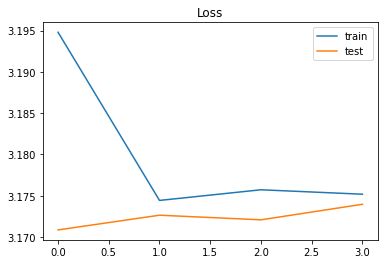

Text(0.5, 1.0, 'Recall@5')

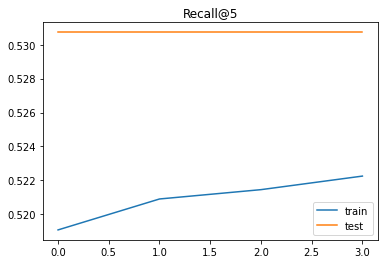

Text(0.5, 1.0, 'Loss')

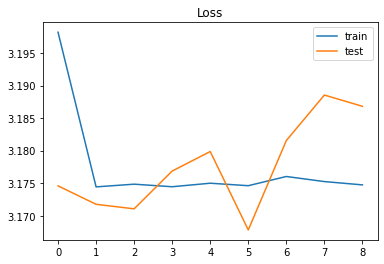

Text(0.5, 1.0, 'Recall@10')

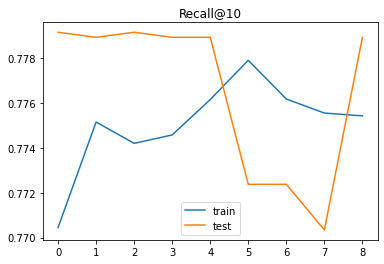

Text(0.5, 1.0, 'Loss')

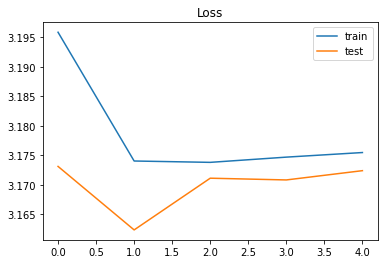

Text(0.5, 1.0, 'Recall@15')

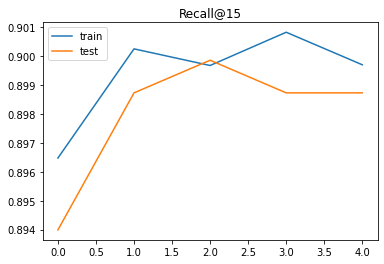

In [17]:
plt.title('Loss')
plt.plot(word_hist1[0].history['loss'], label='train')
plt.plot(word_hist1[0].history['val_loss'], label='test')
plt.legend()
plt.show();

plt.title('Recall@5')
plt.plot(word_hist1[0].history['recall'], label='train')
plt.plot(word_hist1[0].history['val_recall'], label='test')
plt.legend()
plt.show();

plt.title('Loss')
plt.plot(word_hist1[1].history['loss'], label='train')
plt.plot(word_hist1[1].history['val_loss'], label='test')
plt.legend()
plt.show();

plt.title('Recall@10')
plt.plot(word_hist1[1].history['recall_1'], label='train')
plt.plot(word_hist1[1].history['val_recall_1'], label='test')
plt.legend()
plt.show();

plt.title('Loss')
plt.plot(word_hist1[2].history['loss'], label='train')
plt.plot(word_hist1[2].history['val_loss'], label='test')
plt.legend()
plt.show();

plt.title('Recall@15')
plt.plot(word_hist1[2].history['recall_2'], label='train')
plt.plot(word_hist1[2].history['val_recall_2'], label='test')
plt.legend()
plt.show();


In [6]:
#pius_word1.print_plot(2)
pius_word2.preprocessing()
pius_word2.clean_text()
pius_word2.tokenize_df()
pius_word2.labels_to_int()

word_hist2 = []
for topk in list(range(5, 16, 5)):
    pius_word2.set_model(topk_num=topk)
    pius_word2.run_model()

    accr = pius_word2.model.evaluate(pius_word2.X_test, pius_word2.Y_test)
    print('Test set\n Loss: {:0.3f}\n Accuracy: {:0.3f}'.format(accr[0], accr[1]))

    word_hist2.append(pius_word2.history)

<ipython-input-3-0365f3784ca9>:92: FutureWarning:

The default value of regex will change from True to False in a future version.



Found 40173 unique tokens.
X Shape of data tensor: (40602, 250) (2462, 250)
X_ori Shape of data tensor: (40602, 250) (4921, 250)
Shape of label tensor: (1231, 92)
Y Shape of label tensor: (40602, 37) (2462, 37)
X train Shape of data tensor: (40602, 250) X test:  (2462, 250)
Y Shape of label tensor: (40602, 37) X test:  (2462, 37)
Epoch 1/20
571/571 [==============================] - 256s 448ms/step - loss: 3.1991 - recall_3: 0.5185 - accuracy: 0.1249 - val_loss: 3.1729 - val_recall_3: 0.5131 - val_accuracy: 0.1367
Epoch 2/20
571/571 [==============================] - 256s 448ms/step - loss: 3.1736 - recall_3: 0.5231 - accuracy: 0.1282 - val_loss: 3.1711 - val_recall_3: 0.5246 - val_accuracy: 0.1367
Epoch 3/20
571/571 [==============================] - 257s 451ms/step - loss: 3.1737 - recall_3: 0.5212 - accuracy: 0.1296 - val_loss: 3.1583 - val_recall_3: 0.5246 - val_accuracy: 0.1367
Epoch 4/20
571/571 [==============================] - 258s 452ms/step - loss: 3.1750 - recall_3: 0.5225 

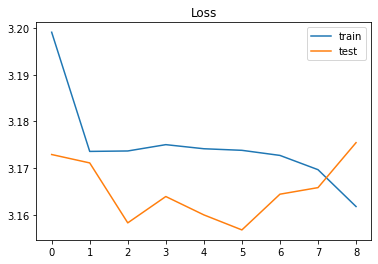

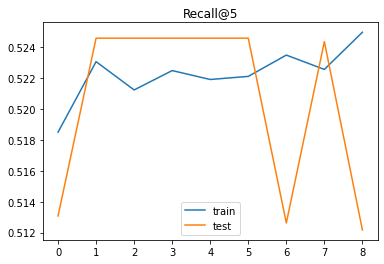

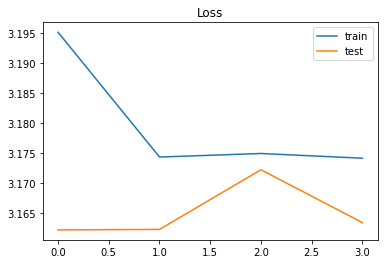

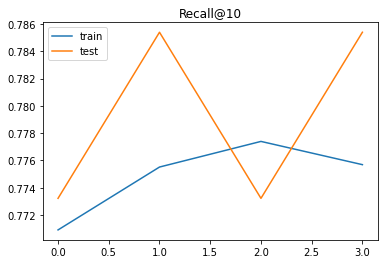

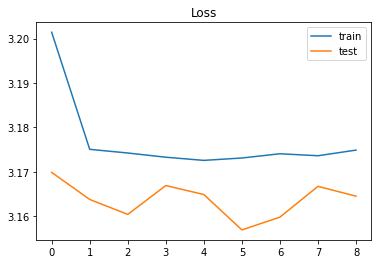

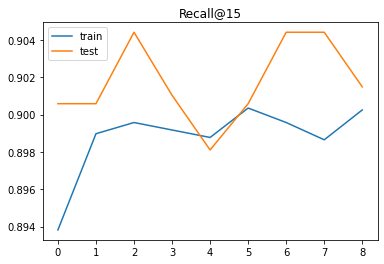

In [18]:
plt.title('Loss')
plt.plot(word_hist2[0].history['loss'], label='train')
plt.plot(word_hist2[0].history['val_loss'], label='test')
plt.legend()
plt.show();

plt.title('Recall@5')
plt.plot(word_hist2[0].history['recall_3'], label='train')
plt.plot(word_hist2[0].history['val_recall_3'], label='test')
plt.legend()
plt.show();

plt.title('Loss')
plt.plot(word_hist2[1].history['loss'], label='train')
plt.plot(word_hist2[1].history['val_loss'], label='test')
plt.legend()
plt.show();

plt.title('Recall@10')
plt.plot(word_hist2[1].history['recall_4'], label='train')
plt.plot(word_hist2[1].history['val_recall_4'], label='test')
plt.legend()
plt.show();

plt.title('Loss')
plt.plot(word_hist2[2].history['loss'], label='train')
plt.plot(word_hist2[2].history['val_loss'], label='test')
plt.legend()
plt.show();

plt.title('Recall@15')
plt.plot(word_hist2[2].history['recall_5'], label='train')
plt.plot(word_hist2[2].history['val_recall_5'], label='test')
plt.legend()
plt.show();

In [7]:
#pius_word1.print_plot(2)
pius_word3.preprocessing()
pius_word3.clean_text()
pius_word3.tokenize_df()
pius_word3.labels_to_int()
word_hist3 = []
for topk in list(range(5, 16, 5)):
    pius_word3.set_model(topk_num=topk)
    pius_word3.run_model()

    accr = pius_word3.model.evaluate(pius_word3.X_test, pius_word3.Y_test)
    print('Test set\n Loss: {:0.3f}\n Accuracy: {:0.3f}'.format(accr[0], accr[1]))

    word_hist3.append(pius_word3.history)

<ipython-input-3-0365f3784ca9>:92: FutureWarning:

The default value of regex will change from True to False in a future version.



Found 19283 unique tokens.
X Shape of data tensor: (40602, 250) (2462, 250)
X_ori Shape of data tensor: (40602, 250) (4921, 250)
Shape of label tensor: (1231, 92)
Y Shape of label tensor: (40602, 37) (2462, 37)
X train Shape of data tensor: (40602, 250) X test:  (2462, 250)
Y Shape of label tensor: (40602, 37) X test:  (2462, 37)
Epoch 1/20
571/571 [==============================] - 277s 484ms/step - loss: 3.1989 - recall_6: 0.5165 - accuracy: 0.1260 - val_loss: 3.1796 - val_recall_6: 0.5233 - val_accuracy: 0.1320
Epoch 2/20
571/571 [==============================] - 275s 482ms/step - loss: 3.1713 - recall_6: 0.5233 - accuracy: 0.1313 - val_loss: 3.1760 - val_recall_6: 0.5233 - val_accuracy: 0.1320
Epoch 3/20
571/571 [==============================] - 275s 482ms/step - loss: 3.1743 - recall_6: 0.5230 - accuracy: 0.1290 - val_loss: 3.1784 - val_recall_6: 0.5233 - val_accuracy: 0.1320
Epoch 4/20
571/571 [==============================] - 275s 482ms/step - loss: 3.1708 - recall_6: 0.5201 

In [8]:
#pius_word1.print_plot(2)
pius_word4.preprocessing()
pius_word4.clean_text()
pius_word4.tokenize_df()
pius_word4.labels_to_int()
word_hist4 = []
for topk in list(range(5, 16, 5)):
    pius_word4.set_model(topk_num=topk)
    pius_word4.run_model()

    accr = pius_word4.model.evaluate(pius_word4.X_test, pius_word4.Y_test)
    print('Test set\n Loss: {:0.3f}\n Accuracy: {:0.3f}'.format(accr[0], accr[1]))

    word_hist4.append(pius_word4.history)

<ipython-input-3-0365f3784ca9>:92: FutureWarning:

The default value of regex will change from True to False in a future version.



Found 29359 unique tokens.
X Shape of data tensor: (40602, 250) (2462, 250)
X_ori Shape of data tensor: (40602, 250) (4921, 250)
Shape of label tensor: (1231, 92)
Y Shape of label tensor: (40602, 37) (2462, 37)
X train Shape of data tensor: (40602, 250) X test:  (2462, 250)
Y Shape of label tensor: (40602, 37) X test:  (2462, 37)
Epoch 1/20
571/571 [==============================] - 304s 532ms/step - loss: 3.1942 - recall_9: 0.5172 - accuracy: 0.1279 - val_loss: 3.2035 - val_recall_9: 0.5229 - val_accuracy: 0.1310
Epoch 2/20
571/571 [==============================] - 304s 533ms/step - loss: 3.1717 - recall_9: 0.5215 - accuracy: 0.1301 - val_loss: 3.2169 - val_recall_9: 0.5229 - val_accuracy: 0.1189
Epoch 3/20
571/571 [==============================] - 302s 529ms/step - loss: 3.1696 - recall_9: 0.5218 - accuracy: 0.1295 - val_loss: 3.2234 - val_recall_9: 0.5229 - val_accuracy: 0.1310
Epoch 4/20
571/571 [==============================] - 302s 529ms/step - loss: 3.1717 - recall_9: 0.5224 

In [ ]:
plt.title('Loss')
plt.plot(word_hist[0].history['loss'], label='train')
plt.plot(word_hist[0].history['val_loss'], label='test')
plt.legend()
plt.show();

plt.title('Recall@5')
plt.plot(word_hist[0].history['recall_3'], label='train')
plt.plot(word_hist[0].history['val_recall_3'], label='test')
plt.legend()
plt.show();

plt.title('Loss')
plt.plot(word_hist[1].history['loss'], label='train')
plt.plot(word_hist[1].history['val_loss'], label='test')
plt.legend()
plt.show();

plt.title('Recall@10')
plt.plot(word_hist[1].history['recall_4'], label='train')
plt.plot(word_hist[1].history['val_recall_4'], label='test')
plt.legend()
plt.show();

plt.title('Loss')
plt.plot(word_hist[2].history['loss'], label='train')
plt.plot(word_hist[2].history['val_loss'], label='test')
plt.legend()
plt.show();

plt.title('Recall@15')
plt.plot(word_hist[2].history['recall_5'], label='train')
plt.plot(word_hist[2].history['val_recall_5'], label='test')
plt.legend()
plt.show();

In [9]:
#pius_word1.print_plot(2)
pius_word5.preprocessing()
pius_word5.clean_text()
pius_word5.tokenize_df()
pius_word5.labels_to_int()
word_hist5 = []
for topk in list(range(5, 16, 5)):
    pius_word5.set_model(topk_num=topk)
    pius_word5.run_model()

    accr = pius_word5.model.evaluate(pius_word5.X_test, pius_word5.Y_test)
    print('Test set\n Loss: {:0.3f}\n Accuracy: {:0.3f}'.format(accr[0], accr[1]))

    word_hist5.append(pius_word5.history)

<ipython-input-3-0365f3784ca9>:92: FutureWarning:

The default value of regex will change from True to False in a future version.



Found 49911 unique tokens.
X Shape of data tensor: (40602, 250) (2462, 250)
X_ori Shape of data tensor: (40602, 250) (4921, 250)
Shape of label tensor: (1231, 92)
Y Shape of label tensor: (40602, 37) (2462, 37)
X train Shape of data tensor: (40602, 250) X test:  (2462, 250)
Y Shape of label tensor: (40602, 37) X test:  (2462, 37)
Epoch 1/20
571/571 [==============================] - 277s 485ms/step - loss: 3.2049 - recall_12: 0.5147 - accuracy: 0.1252 - val_loss: 3.1364 - val_recall_12: 0.5395 - val_accuracy: 0.1347
Epoch 2/20
571/571 [==============================] - 277s 485ms/step - loss: 3.1782 - recall_12: 0.5209 - accuracy: 0.1273 - val_loss: 3.1579 - val_recall_12: 0.5395 - val_accuracy: 0.1347
Epoch 3/20
571/571 [==============================] - 278s 486ms/step - loss: 3.1764 - recall_12: 0.5208 - accuracy: 0.1298 - val_loss: 3.1407 - val_recall_12: 0.5395 - val_accuracy: 0.1347
Epoch 4/20
77/77 [==============================] - 3s 37ms/step - loss: 3.3980 - recall_12: 0.460

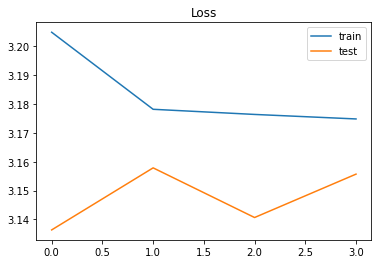

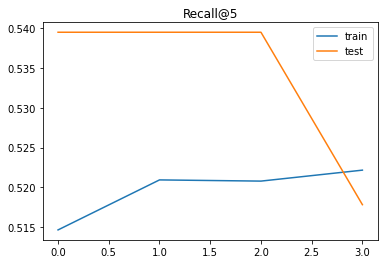

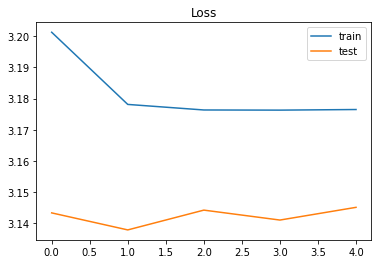

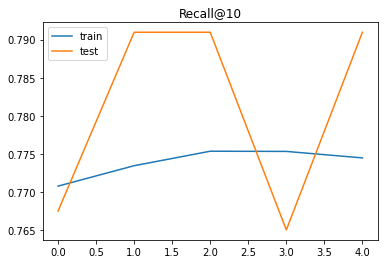

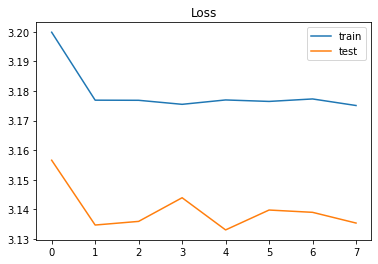

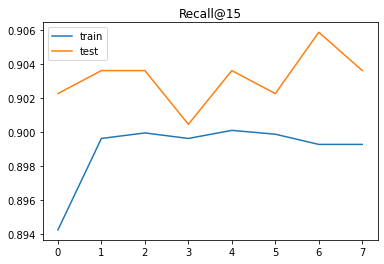

In [22]:
plt.title('Loss')
plt.plot(word_hist5[0].history['loss'], label='train')
plt.plot(word_hist5[0].history['val_loss'], label='test')
plt.legend()
plt.show();

plt.title('Recall@5')
plt.plot(word_hist5[0].history['recall_12'], label='train')
plt.plot(word_hist5[0].history['val_recall_12'], label='test')
plt.legend()
plt.show();

plt.title('Loss')
plt.plot(word_hist5[1].history['loss'], label='train')
plt.plot(word_hist5[1].history['val_loss'], label='test')
plt.legend()
plt.show();

plt.title('Recall@10')
plt.plot(word_hist5[1].history['recall_13'], label='train')
plt.plot(word_hist5[1].history['val_recall_13'], label='test')
plt.legend()
plt.show();

plt.title('Loss')
plt.plot(word_hist5[2].history['loss'], label='train')
plt.plot(word_hist5[2].history['val_loss'], label='test')
plt.legend()
plt.show();

plt.title('Recall@15')
plt.plot(word_hist5[2].history['recall_14'], label='train')
plt.plot(word_hist5[2].history['val_recall_14'], label='test')
plt.legend()
plt.show();

In [10]:
#pius_word1.print_plot(2)
pius_word6.preprocessing()
pius_word6.clean_text()
pius_word6.tokenize_df()
pius_word6.labels_to_int()
word_hist6 = []
for topk in list(range(5, 16, 5)):
    pius_word6.set_model(topk_num=topk)
    pius_word6.run_model()

    accr = pius_word6.model.evaluate(pius_word6.X_test, pius_word6.Y_test)
    print('Test set\n Loss: {:0.3f}\n Accuracy: {:0.3f}'.format(accr[0], accr[1]))

    word_hist6.append(pius_word6.history)

<ipython-input-3-0365f3784ca9>:92: FutureWarning:

The default value of regex will change from True to False in a future version.



Found 24450 unique tokens.
X Shape of data tensor: (40602, 250) (2462, 250)
X_ori Shape of data tensor: (40602, 250) (4921, 250)
Shape of label tensor: (1231, 92)
Y Shape of label tensor: (40602, 37) (2462, 37)
X train Shape of data tensor: (40602, 250) X test:  (2462, 250)
Y Shape of label tensor: (40602, 37) X test:  (2462, 37)
Epoch 1/20
571/571 [==============================] - 270s 473ms/step - loss: 3.1983 - recall_15: 0.5146 - accuracy: 0.1261 - val_loss: 3.1543 - val_recall_15: 0.5145 - val_accuracy: 0.1362
Epoch 2/20
571/571 [==============================] - 268s 469ms/step - loss: 3.1753 - recall_15: 0.5212 - accuracy: 0.1288 - val_loss: 3.1595 - val_recall_15: 0.5367 - val_accuracy: 0.1005
Epoch 3/20
571/571 [==============================] - 270s 472ms/step - loss: 3.1748 - recall_15: 0.5213 - accuracy: 0.1283 - val_loss: 3.1471 - val_recall_15: 0.5367 - val_accuracy: 0.1362
Epoch 4/20
571/571 [==============================] - 270s 473ms/step - loss: 3.1736 - recall_15: 

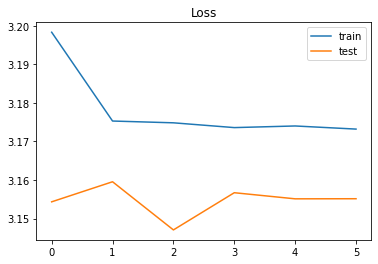

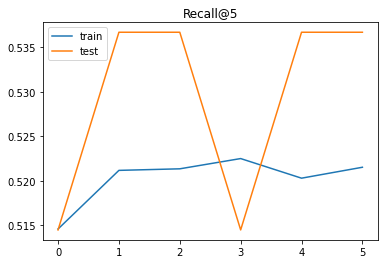

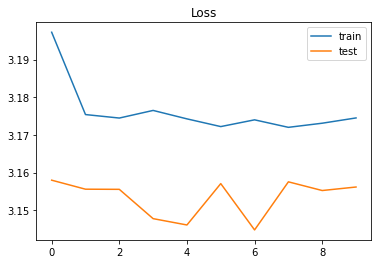

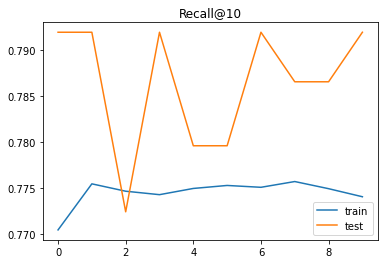

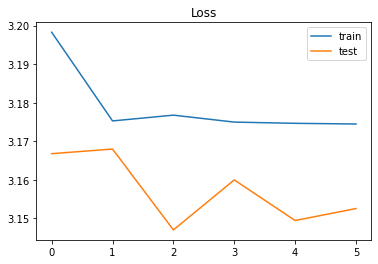

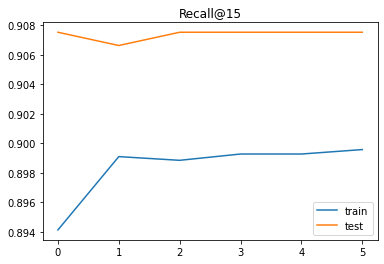

In [21]:
plt.title('Loss')
plt.plot(word_hist6[0].history['loss'], label='train')
plt.plot(word_hist6[0].history['val_loss'], label='test')
plt.legend()
plt.show();

plt.title('Recall@5')
plt.plot(word_hist6[0].history['recall_15'], label='train')
plt.plot(word_hist6[0].history['val_recall_15'], label='test')
plt.legend()
plt.show();

plt.title('Loss')
plt.plot(word_hist6[1].history['loss'], label='train')
plt.plot(word_hist6[1].history['val_loss'], label='test')
plt.legend()
plt.show();

plt.title('Recall@10')
plt.plot(word_hist6[1].history['recall_16'], label='train')
plt.plot(word_hist6[1].history['val_recall_16'], label='test')
plt.legend()
plt.show();

plt.title('Loss')
plt.plot(word_hist6[2].history['loss'], label='train')
plt.plot(word_hist6[2].history['val_loss'], label='test')
plt.legend()
plt.show();

plt.title('Recall@15')
plt.plot(word_hist6[2].history['recall_17'], label='train')
plt.plot(word_hist6[2].history['val_recall_17'], label='test')
plt.legend()
plt.show();

In [11]:
#pius_word1.print_plot(2)
pius_word7.preprocessing()
pius_word7.clean_text()
pius_word7.tokenize_df()
pius_word7.labels_to_int()
word_hist7 = []
for topk in list(range(5, 16, 5)):
    pius_word7.set_model(topk_num=topk)
    pius_word7.run_model()

    accr = pius_word7.model.evaluate(pius_word7.X_test, pius_word7.Y_test)
    print('Test set\n Loss: {:0.3f}\n Accuracy: {:0.3f}'.format(accr[0], accr[1]))

    word_hist7.append(pius_word7.history)


<ipython-input-3-0365f3784ca9>:92: FutureWarning:

The default value of regex will change from True to False in a future version.



Found 49852 unique tokens.
X Shape of data tensor: (40602, 250) (2462, 250)
X_ori Shape of data tensor: (40602, 250) (4921, 250)
Shape of label tensor: (1231, 92)
Y Shape of label tensor: (40602, 37) (2462, 37)
X train Shape of data tensor: (40602, 250) X test:  (2462, 250)
Y Shape of label tensor: (40602, 37) X test:  (2462, 37)
Epoch 1/20
571/571 [==============================] - 282s 494ms/step - loss: 3.1967 - recall_18: 0.5185 - accuracy: 0.1277 - val_loss: 3.1894 - val_recall_18: 0.5228 - val_accuracy: 0.1039
Epoch 2/20
571/571 [==============================] - 285s 500ms/step - loss: 3.1746 - recall_18: 0.5223 - accuracy: 0.1279 - val_loss: 3.1830 - val_recall_18: 0.5228 - val_accuracy: 0.1320
Epoch 3/20
571/571 [==============================] - 285s 499ms/step - loss: 3.1732 - recall_18: 0.5212 - accuracy: 0.1290 - val_loss: 3.1720 - val_recall_18: 0.5228 - val_accuracy: 0.1320
Epoch 4/20
571/571 [==============================] - 285s 499ms/step - loss: 3.1736 - recall_18: 

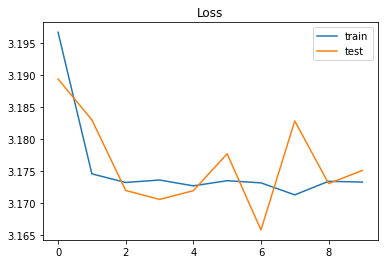

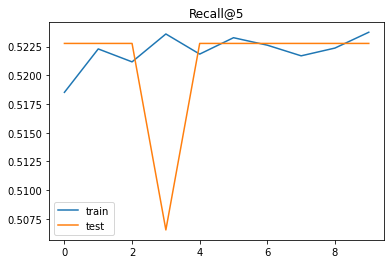

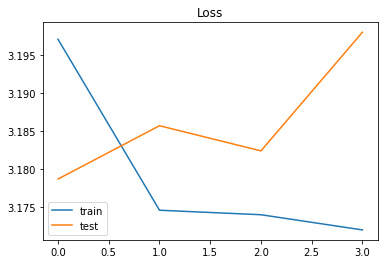

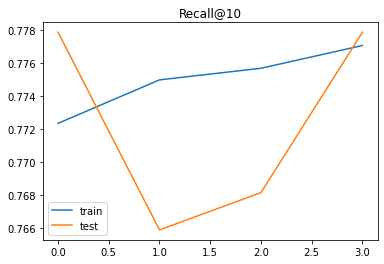

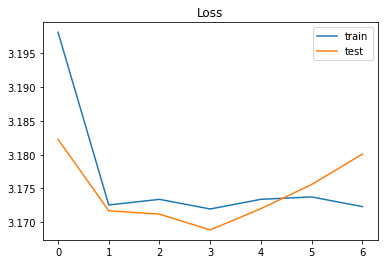

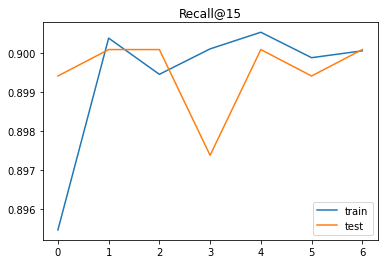

In [20]:
plt.title('Loss')
plt.plot(word_hist7[0].history['loss'], label='train')
plt.plot(word_hist7[0].history['val_loss'], label='test')
plt.legend()
plt.show();

plt.title('Recall@5')
plt.plot(word_hist7[0].history['recall_18'], label='train')
plt.plot(word_hist7[0].history['val_recall_18'], label='test')
plt.legend()
plt.show();

plt.title('Loss')
plt.plot(word_hist7[1].history['loss'], label='train')
plt.plot(word_hist7[1].history['val_loss'], label='test')
plt.legend()
plt.show();

plt.title('Recall@10')
plt.plot(word_hist7[1].history['recall_19'], label='train')
plt.plot(word_hist7[1].history['val_recall_19'], label='test')
plt.legend()
plt.show();

plt.title('Loss')
plt.plot(word_hist7[2].history['loss'], label='train')
plt.plot(word_hist7[2].history['val_loss'], label='test')
plt.legend()
plt.show();

plt.title('Recall@15')
plt.plot(word_hist7[2].history['recall_20'], label='train')
plt.plot(word_hist7[2].history['val_recall_20'], label='test')
plt.legend()
plt.show();

In [12]:
'''plt.title('Loss')
plt.plot(pius_word7.history.history['loss'], label='train')
plt.plot(pius_word7.history.history['val_loss'], label='test')
plt.legend()
plt.show();

plt.title('Accuracy')
plt.plot(pius_word7.history.history['recall'], label='train')
plt.plot(pius_word7.history.history['val_recall'], label='test')
plt.legend()
plt.show();'''

"plt.title('Loss')\nplt.plot(pius_word7.history.history['loss'], label='train')\nplt.plot(pius_word7.history.history['val_loss'], label='test')\nplt.legend()\nplt.show();\n\nplt.title('Accuracy')\nplt.plot(pius_word7.history.history['recall'], label='train')\nplt.plot(pius_word7.history.history['val_recall'], label='test')\nplt.legend()\nplt.show();"

In [13]:
accr = pius_word1.model.evaluate(pius_word1.X_test, pius_word1.Y_test)
print('Test set\n Loss: {:0.3f}\n Accuracy: {:0.3f}'.format(accr[0], accr[1]))

77/77 [==============================] - 4s 56ms/step - loss: 3.3561 - recall_2: 0.8340 - accuracy: 0.0999
Test set
 Loss: 3.356
 Accuracy: 0.834


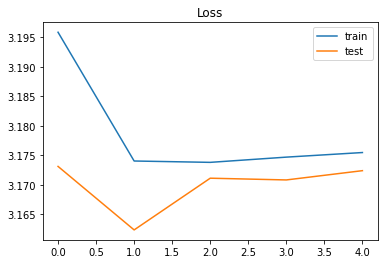

KeyError: 'recall_7'

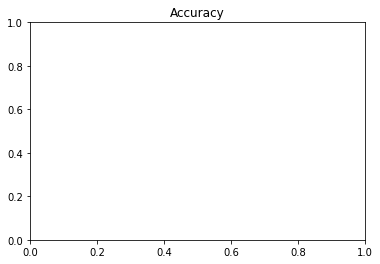

In [14]:
plt.title('Loss')
plt.plot(pius_word1.history.history['loss'], label='train')
plt.plot(pius_word1.history.history['val_loss'], label='test')
plt.legend()
plt.show();

plt.title('Accuracy')
plt.plot(pius_word1.history.history['recall_7'], label='train')
plt.plot(pius_word1.history.history['val_recall_7'], label='test')
plt.legend()
plt.show();

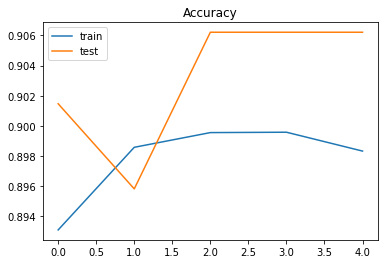

In [ ]:
plt.title('Accuracy')
plt.plot(pius_word1.history.history['recall_7'], label='train')
plt.plot(pius_word1.history.history['val_recall_7'], label='test')
plt.legend()
plt.show();

In [ ]:
from keras.utils import plot_model
plot_model(pius_word1.model, show_shapes = True, show_layer_names = True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [ ]:
pius_word1.df['component'].value_counts().sort_values(ascending=False).iplot(kind = 'bar', yTitle = 'Number of Complaints', title = 'Number complaints in each component')

In [ ]:
'''pius_word1.df['component'].value_counts().sort_values(ascending=False).iplot(kind = 'bar', yTitle = 'Number of Complaints', title = 'Number complaints in each component')'''

In [ ]:
'''def set_model():
    model = Sequential()
    model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_train.shape[1]))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(37, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])'''


In [25]:
word_hist_all = []
for i in range(3):
    word_hist_all.append(word_hist1[i].history)
for i in range(3):
    word_hist_all.append(word_hist2[i].history)
for i in range(3):
    word_hist_all.append(word_hist3[i].history)
for i in range(3):
    word_hist_all.append(word_hist4[i].history)
for i in range(3):
    word_hist_all.append(word_hist5[i].history)
for i in range(3):
    word_hist_all.append(word_hist6[i].history)
for i in range(3):
    word_hist_all.append(word_hist7[i].history)


In [32]:
for i in range(3):
    word_hist_all.append(word_hist7[i].history)
    
for x in range(21):
    # convert the history dict to a pandas DataFrame
    hist_df = pd.DataFrame(word_hist_all[x])

    # save to csv
    hist_csv_file = 'history/trainhistoryRecallat{}_data{}.csv'.format(int((x%3)*5+5), int(x/3+1))
    with open(hist_csv_file, mode = 'w') as f:
        hist_df.to_csv(f)

In [6]:
'''model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))

model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
#model.add(LSTM(100, return_sequences=True))
model.add(Dense(37, activation='sigmoid'))
'''
pius_word8.X_train.shape

filter_length = 300
num_classes = 37
modelCNN = tf.keras.Sequential()
modelCNN.add(Embedding(MAX_NB_WORDS, 20, input_length= MAX_SEQUENCE_LENGTH))
modelCNN.add(Dropout(0.1))
modelCNN.add(tf.keras.layers.Conv1D(filter_length, 3, padding = 'valid', activation = 'relu', strides = 1))
modelCNN.add(tf.keras.layers.GlobalMaxPool1D())
modelCNN.add(Dense(num_classes))
modelCNN.add(tf.keras.layers.Activation('sigmoid'))

modelCNN.compile(optimizer = 'adam', loss  = 'binary_crossentropy', metrics = [tf.keras.metrics.Recall(top_k = 5)])

"model = Sequential()\nmodel.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))\n\nmodel.add(SpatialDropout1D(0.2))\nmodel.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))\n#model.add(LSTM(100, return_sequences=True))\nmodel.add(Dense(37, activation='sigmoid'))\n"

(40602, 250)

In [ ]:


for topk in range(5, 16, 5):
    filter_length = 300
    num_classes = 37
    modelCNN = tf.keras.Sequential()
    modelCNN.add(Embedding(MAX_NB_WORDS, 20, input_length= MAX_SEQUENCE_LENGTH))
    modelCNN.add(Dropout(0.1))
    modelCNN.add(tf.keras.layers.Conv1D(filter_length, 3, padding = 'valid', activation = 'relu', strides = 1))
    modelCNN.add(tf.keras.layers.GlobalMaxPool1D())
    modelCNN.add(Dense(num_classes))
    modelCNN.add(tf.keras.layers.Activation('sigmoid'))

    modelCNN.summary()
    modelCNN.compile(optimizer = 'adam', loss  = 'binary_crossentropy', metrics = [tf.keras.metrics.Recall(top_k = topk)])
    modelCNN.fit(pius_word8.X_train, pius_word8.Y_train, epochs=20, batch_size = 64, validation_split=0.1)

    accr = pius_word1.modelCNN.evaluate(pius_word1.X_test, pius_word1.Y_test)
    print('Test set\n Loss: {:0.3f}\n Accuracy: {:0.3f}'.format(accr[0], accr[1]))

    word_hist1.append(pius_word1.history)

Error: Session cannot generate requests

In [36]:
accr = modelCNN.evaluate(pius_word8.X_test,pius_word8.Y_test)
print('Test set\n  Loss: {:0.3f}\n  recall: {:0.3f}'.format(accr[0],accr[1]))

77/77 [==============================] - 1s 8ms/step - loss: 0.1625 - recall_6: 0.3452
Test set
  Loss: 0.163
  recall: 0.345
